In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#model = Sequential()
#model.add(LSTM(units=50, activation="tanh", input_shape=(n_steps, n_futures)))
#model.add(Dense(1))
#model.compile(loss="mse", optimizer="adam")
#model.summary()

In [71]:
data = pd.read_csv("Datos_Acciones.csv", index_col="Date", parse_dates=True)

data

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM
...,...,...,...,...,...,...
2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA


In [72]:
data.describe()

,Open,High,Low,Close,Volume
count,93587.000000,93602.000000,93592.000000,93612.000000,9.361200e+04
mean,85.623260,86.387045,84.836664,85.641753,2.015667e+07
std,108.151723,108.956365,107.225361,108.121106,3.442108e+07
min,6.750000,7.170000,0.000000,6.660000,0.000000e+00
25%,33.950000,34.290000,33.600000,33.960000,5.040180e+06
50%,60.040000,60.630000,59.490000,60.050000,9.701142e+06
75%,94.000000,94.740000,93.250000,94.012500,2.075222e+07
max,1204.880000,1213.410000,1191.150000,1195.830000,8.432640e+08


In [73]:
(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93612 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    93587 non-null  float64
 1   High    93602 non-null  float64
 2   Low     93592 non-null  float64
 3   Close   93612 non-null  float64
 4   Volume  93612 non-null  int64  
 5   Name    93612 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 5.0+ MB


In [77]:
#cargar datos de entrenamiento
train_data = pd.read_csv("Datos_Acciones.csv")
train_data_appl = train_data[train_data["Name"] == "AAPL"][["Open",'High', 'Low', 'Close', 'Volume']]

In [109]:
# Limpieza de datos
train_data_appl.replace(['---', '               ---', 'NaN', '', ' '], np.nan, inplace=True)
imputer = SimpleImputer(strategy='mean')
train_data_appl = pd.DataFrame(imputer.fit_transform(train_data_appl), columns=train_data_appl.columns, index=train_data_appl.index)

<Axes: >

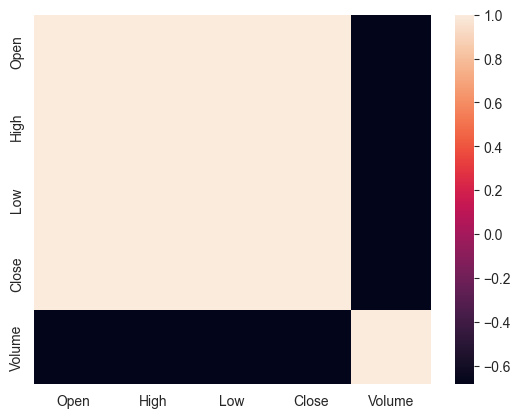

In [110]:
sns.heatmap(train_data_appl.corr())


In [111]:
#escalado de datos
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_data_appl)

#crear secuencias de datos para el entrenamiento
def create_dataset(dataset, look_back = 60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), : ]
        X.append(a)
        Y.append(dataset[i + look_back, 0 ])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled,60)

In [112]:
#modelo LSTM
model = Sequential([LSTM(100, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True),Dropout(0.2), LSTM(100, return_sequences = False), Dense(1)])

model.compile(loss="mse", optimizer= Adam(learning_rate = 0.01))
model.summary()

/Users/passoriano/Documents/PYCHARM PROYECTS/.venv1/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 60, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,901 (480.08 KB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
#entrenar el modelo

model.fit(X_train,y_train,epochs = 50, batch_size = 32, verbose = 1)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1863
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 7.2626e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 5.2614e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 5.2774e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 3.9169e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 3.5544e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3.2654e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.6230e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.7942e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3.4461e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3.9774e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.8775e-04
Epoch 13/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3.8080e-04
Epoch 14/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 3.1680e-04
Epoch 15/50
93/93 ━

In [100]:
new_data = pd.read_csv("New_data2.csv", sep=",")
new_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')

In [114]:
# Preparar los datos reales de 2024 para comparación
real_data_2017 = pd.read_csv("New_data2.csv", index_col='Date', parse_dates=True)
real_data_2017 = real_data_2017[["Open",'High', 'Low', 'Close', 'Volume']]
real_data_2017.replace(['---', '               ---', 'NaN', '', ' '], np.nan, inplace=True)
real_data_2017 = pd.DataFrame(imputer.transform(real_data_2017), columns=real_data_2017.columns, index=real_data_2017.index)
real_scaled = scaler.transform(real_data_2017)


In [118]:
# Crear datos de entrada para predicción
X_real, _ = create_dataset(np.vstack([train_scaled[-60:], real_scaled]), 60)

# Predicciones
predictions_scaled = model.predict(X_real)
fake_full = np.zeros((len(predictions_scaled), real_scaled.shape[1]))
fake_full[:, 3] = predictions_scaled[:, 0]
predictions = scaler.inverse_transform(fake_full)[:, 3]

# Datos reales para comparar
real_demand = scaler.inverse_transform(real_scaled)[:, 0]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


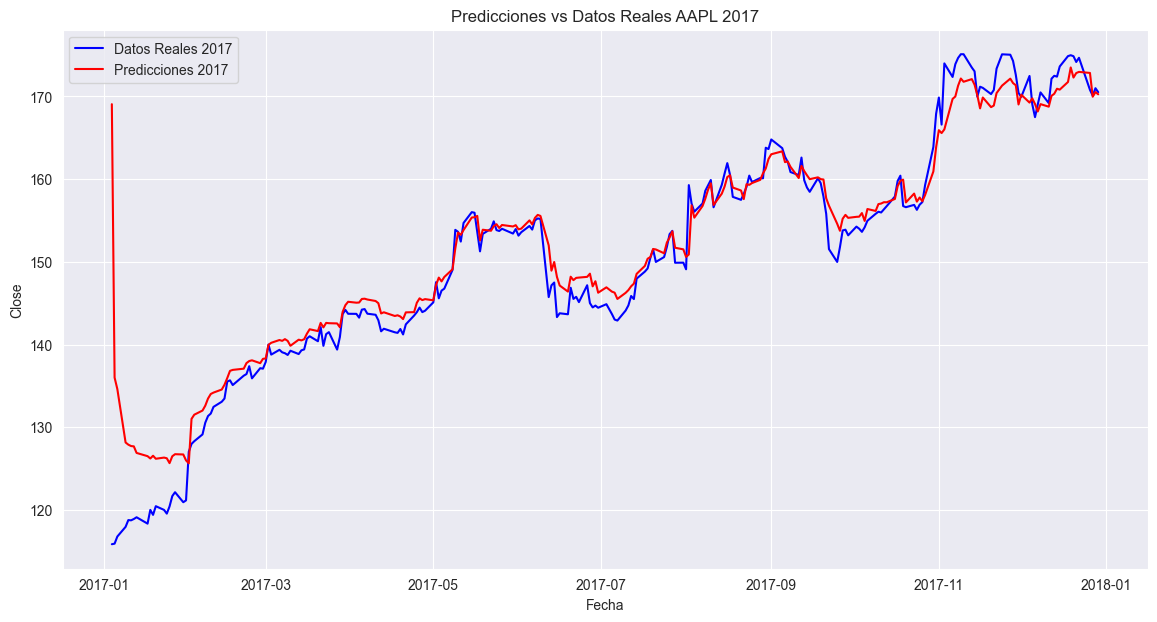

In [121]:
# Graficar
plt.figure(figsize=(14, 7))
plt.plot(real_data_2017.index, real_demand, label='Datos Reales 2017', color='blue')
plt.plot(real_data_2017.index[:len(predictions)], predictions, label='Predicciones 2017', color='red')
plt.title('Predicciones vs Datos Reales AAPL 2017')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()


In [126]:
import plotly.graph_objects as go
import pandas as pd
from sklearn.metrics import r2_score

# Asegurarse de que tanto 'real_demand' como 'predictions' tienen el mismo índice de tiempo
real_demand = pd.Series(real_demand[:len(predictions)], index=real_data_2017.index[:len(predictions)])
predictions_series = pd.Series(predictions, index=real_data_2017.index[:len(predictions)])

# Crear una lista para almacenar los R-squared de cada mes
r_squared_monthly = []

# Agrupar los datos por mes y calcular el R-squared para cada mes
for month, group in real_demand.groupby(real_demand.index.month):
    # Extraer las predicciones correspondientes para ese mes
    pred_for_month = predictions_series[group.index]

    # Calcular el R-squared
    r_squared = r2_score(group, pred_for_month)

    # Almacenar el resultado
    r_squared_monthly.append((month, r_squared))
    print(f'R-squared para el mes {month}: {r_squared}')

# Crear la figura usando Plotly para una mejor interactividad y presentación
fig = go.Figure()

# Añadir los datos reales a la gráfica
fig.add_trace(go.Scatter(x=real_data_2017.index, y=real_demand, mode='lines', name='Datos Reales 2017', line=dict(color='blue')))

# Añadir las predicciones a la gráfica
fig.add_trace(go.Scatter(x=real_data_2017.index[:len(predictions)], y=predictions, mode='lines', name='Predicciones 2017', line=dict(color='red')))

# Configuración adicional del gráfico
fig.update_layout(
    title='Comparación de Predicciones vs Datos Reales AAPL 2017',
    xaxis_title='Fecha',
    yaxis_title='Close',
    legend_title='Leyenda'
)

# Mostrar la gráfica
fig.show()

# Imprimir los R-squared mensuales
for month, r_squared in r_squared_monthly:
    print(f"R-squared para el mes {month}: {r_squared:.4f}")

R-squared para el mes 1: -76.08490588422889
R-squared para el mes 2: 0.6836190397002327
R-squared para el mes 3: 0.35550939598253095
R-squared para el mes 4: -1.214359903753829
R-squared para el mes 5: 0.9018702223833069
R-squared para el mes 6: 0.6493317789128511
R-squared para el mes 7: 0.7705116497428695
R-squared para el mes 8: 0.5032546859245381
R-squared para el mes 9: 0.7804622263589992
R-squared para el mes 10: 0.7600962872110294
R-squared para el mes 11: -0.8511554023439591
R-squared para el mes 12: 0.3638749439604899


R-squared para el mes 1: -76.0849
R-squared para el mes 2: 0.6836
R-squared para el mes 3: 0.3555
R-squared para el mes 4: -1.2144
R-squared para el mes 5: 0.9019
R-squared para el mes 6: 0.6493
R-squared para el mes 7: 0.7705
R-squared para el mes 8: 0.5033
R-squared para el mes 9: 0.7805
R-squared para el mes 10: 0.7601
R-squared para el mes 11: -0.8512
R-squared para el mes 12: 0.3639
